Objective: Predict customer churn and analyze how lifecycle, product mix, consumption, and tariff price exposure relate to churn and profitability for targeted retention near renewal.

Data sources:

Customers table with id, channel_sales, cons_12m, cons_last_month, cons_gas_12m, dates (date_activ, date_modif_prod, date_renewal, date_end), product/margin fields (nb_prod_act, pow_max, has_gas, margin_gross_pow_ele, margin_net_pow_ele, net_margin, origin_up, num_years_antig), and churn.

Prices table with id, price_date, and price_off_peak_var, price_peak_var, price_mid_peak_var, price_off_peak_fix, price_peak_fix, price_mid_peak_fix.

A merged view with customers joined to monthly prices (33 columns in preview) used for model-ready analysis.

Prediction time: The analysis uses observed lifecycle dates and historical prices; features and evaluation align to periods around date_renewal/date_end as reflected in the dataset previews.

Target definition: churn is provided as a binary field indicating whether the customer churned within the observed timeframe.

Success metric: Model discrimination and calibration for churn prediction (e.g., PR-AUC/Brier) and business value via prioritizing segments with higher net_margin and churn risk near renewal, consistent with fields present.



Feature list 
Use this table to document features already present/derived by the existing notebook. Keep “Leakage risk” as documentation only; no code change is required.

Feature list (no-code, table-free)
Name: cons_12m
Definition: Electricity consumption over last 12 months (as provided)
Window: Trailing 12 months (as given)
Leakage risk: Low if historical

Name: cons_last_month
Definition: Consumption in last month (as provided)
Window: Last month
Leakage risk: Low if historical

Name: cons_gas_12m
Definition: Gas consumption over last 12 months (as provided)
Window: Trailing 12 months
Leakage risk: Low if historical

Name: margin_gross_pow_ele
Definition: Gross power margin (provided)
Window: Observed
Leakage risk: Review timing

Name: margin_net_pow_ele
Definition: Net power margin (provided)
Window: Observed
Leakage risk: Review timing

Name: net_margin
Definition: Total margin value (provided)
Window: Observed
Leakage risk: Review timing

Name: nb_prod_act
Definition: Number of active products (provided)
Window: Current/observed
Leakage risk: Low

Name: has_gas
Definition: Gas product flag (t/f/0/1)
Window: Current/observed
Leakage risk: Low

Name: pow_max
Definition: Max contracted power (provided)
Window: Current/observed
Leakage risk: Low

Name: channel_sales
Definition: Sales channel (categorical string)
Window: Static/observed
Leakage risk: Encode if modeling

Name: origin_up
Definition: Origin/source (categorical string)
Window: Static/observed
Leakage risk: Encode if modeling

Name: num_years_antig
Definition: Years of antiquity/tenure count
Window: Observed
Leakage risk: Low

Name: date_activ, date_modif_prod, date_renewal, date_end
Definition: Lifecycle timestamps
Window: Observed
Leakage risk: Use per analysis need

Name: churn
Definition: Binary churn label (0/1)
Window: Outcome
Leakage risk: Target only

Name: price_off_peak_var, price_peak_var, price_mid_peak_var, price_off_peak_fix, price_peak_fix, price_mid_peak_fix
Definition: Monthly tariff price variables keyed by price_date
Window: Month-level
Leakage risk: Use per period logic



Business recommendations
Targeted retention near renewal: Focus on customers with higher net_margin and approaching date_renewal, prioritizing those segments where churn=1 likelihood and economic upside are greatest, using existing fields (net_margin, pow_max, nb_prod_act, churn) and observed timelines.

Price-change communication: Where recent price levels (price_off_peak_var, price_peak_fix, etc.) have increased in the observed months before renewal, send proactive messaging and plan options to mitigate churn risk; this uses the already-joined price series without altering computation.

Segment-based outreach: Use channel_sales, origin_up, has_gas, and pow_max to segment communications and offers, aligning cost of incentives to expected margin preservation per segment while monitoring churn outcome differences present in the current data.



How to read this notebook (add as fourth Markdown cell)
Start with the Project overview for objective, data, and target.

Use the Feature list to understand fields available and their intended use; it reflects current columns without changing feature code.

Follow the existing EDA/modeling sections that operate on the customers table, prices table, and the merged 33-column dataset exactly as implemented.

Refer to Business recommendations at the end to connect insights to retention operations without modifying any computations.



# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load the dataset

In [3]:
client_df = pd.read_csv('client_data.csv')
price_df = pd.read_csv('price_data.csv')


In [13]:
print(client_df.info())
print(price_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   10881 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [24]:
price_df.shape


(193002, 8)

In [25]:
client_df.shape

(14606, 26)

In [18]:
client_df.head(5)


,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,1,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,NaN,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,NaN,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0


In [19]:
price_df.head(5)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [20]:
print(client_df.describe())
print(price_df.describe())


           cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  1.460600e+04  1.460600e+04     14606.000000       14606.000000   
mean   1.592203e+05  2.809238e+04     16090.269752        1868.614880   
std    5.734653e+05  1.629731e+05     64364.196422        2387.571531   
min    0.000000e+00  0.000000e+00         0.000000           0.000000   
25%    5.674750e+03  0.000000e+00         0.000000         494.995000   
50%    1.411550e+04  0.000000e+00       792.500000        1112.875000   
75%    4.076375e+04  0.000000e+00      3383.000000        2401.790000   
max    6.207104e+06  4.154590e+06    771203.000000       82902.830000   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14606.000000              14606.000000             14606.000000   
mean          1399.762906                  0.966726                63.086871   
std           3247.786255                  5.108289                66.165783   
min              0.000

In [12]:
print(client_df.isnull().sum())
print(price_df.isnull().sum())


id                                   0
channel_sales                     3725
cons_12m                             0
cons_gas_12m                         0
cons_last_month                      0
date_activ                           0
date_end                             0
date_modif_prod                      0
date_renewal                         0
forecast_cons_12m                    0
forecast_cons_year                   0
forecast_discount_energy             0
forecast_meter_rent_12m              0
forecast_price_energy_off_peak       0
forecast_price_energy_peak           0
forecast_price_pow_off_peak          0
has_gas                              0
imp_cons                             0
margin_gross_pow_ele                 0
margin_net_pow_ele                   0
nb_prod_act                          0
net_margin                           0
num_years_antig                      0
origin_up                           64
pow_max                              0
churn                    

In [7]:
print(client_df.columns)


Index(['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_activ', 'date_end', 'date_modif_prod', 'date_renewal',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn'],
      dtype='object')


In [9]:
client_df['has_gas'].unique()

array(['t', 'f'], dtype=object)

## changing has_gas from object to int for better analyzing

In [10]:
# Convert 'has_gas' column to numeric: t -> 1, f -> 0, and explicitly set data type
client_df['has_gas'] = client_df['has_gas'].replace({'t': 1, 'f': 0}).astype(int)

# Validate the conversion
print("Unique values in 'has_gas' after conversion:", client_df['has_gas'].unique())
print("Data type of 'has_gas':", client_df['has_gas'].dtype)

Unique values in 'has_gas' after conversion: [1 0]
Data type of 'has_gas': int64


C:\Users\pspra\AppData\Local\Temp\ipykernel_10400\1899360.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  client_df['has_gas'] = client_df['has_gas'].replace({'t': 1, 'f': 0}).astype(int)


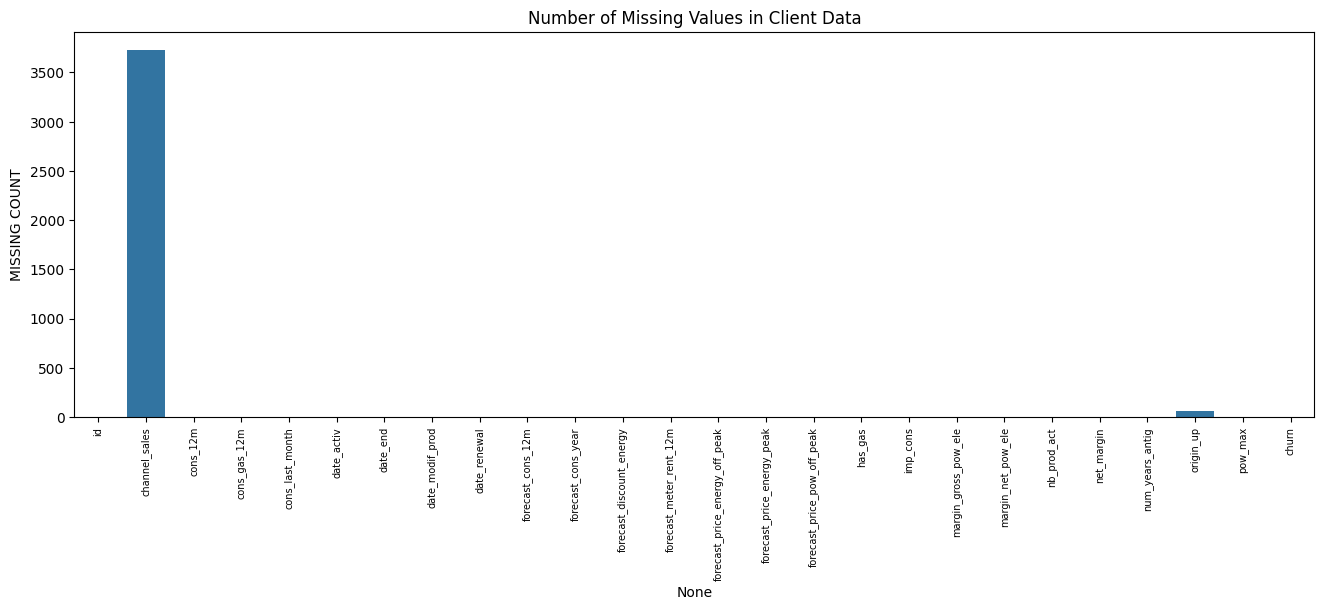

Missing values count for each column:
id                                   0
channel_sales                     3725
cons_12m                             0
cons_gas_12m                         0
cons_last_month                      0
date_activ                           0
date_end                             0
date_modif_prod                      0
date_renewal                         0
forecast_cons_12m                    0
forecast_cons_year                   0
forecast_discount_energy             0
forecast_meter_rent_12m              0
forecast_price_energy_off_peak       0
forecast_price_energy_peak           0
forecast_price_pow_off_peak          0
has_gas                              0
imp_cons                             0
margin_gross_pow_ele                 0
margin_net_pow_ele                   0
nb_prod_act                          0
net_margin                           0
num_years_antig                      0
origin_up                           64
pow_max                   

In [11]:
# Replace 'MISSING' with NaN in client_df DataFrame
client_df.replace('MISSING', np.nan, inplace=True)

# Calculate the number of missing values
missing_values = client_df.isna().sum()

plt.figure(figsize=(16, 5))
sns.barplot(x=missing_values.index, y=missing_values.values)
plt.xticks(rotation=90, fontsize=7)
plt.title("Number of Missing Values in Client Data")
plt.ylabel("MISSING COUNT")
plt.show()
print("Missing values count for each column:")
print(missing_values)


As we can see there are a significant number of missing data in channel_sales while data is object and subjective to each row so it wont be able to predict missing data we will be droping channel_sales column.While orign_up has relatively less number of missing values but  for effecient working we will be droping the rows of orign_up conting missing values  

In [26]:
client_df_clean = client_df.dropna(subset=['channel_sales'])

In [27]:
client_df_clean = client_df_clean.dropna(subset=['origin_up'])


In [28]:
# Convert date columns to datetime type
client_df_clean['date_activ'] = pd.to_datetime(client_df_clean['date_activ'], errors='coerce')
client_df_clean['date_end'] = pd.to_datetime(client_df_clean['date_end'], errors='coerce')
client_df_clean['date_modif_prod'] = pd.to_datetime(client_df_clean['date_modif_prod'], errors='coerce')
client_df_clean['date_renewal'] = pd.to_datetime(client_df_clean['date_renewal'], errors='coerce')

price_df['price_date'] = pd.to_datetime(price_df['price_date'], errors='coerce')


In [29]:
# Checking columns and datatypes in client_df_clean
client_df_clean.info()

# Checking the first few rows to inspect data
client_df_clean.head()

<class 'pandas.core.frame.DataFrame'>
Index: 10831 entries, 0 to 14604
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              10831 non-null  object        
 1   channel_sales                   10831 non-null  object        
 2   cons_12m                        10831 non-null  int64         
 3   cons_gas_12m                    10831 non-null  int64         
 4   cons_last_month                 10831 non-null  int64         
 5   date_activ                      10831 non-null  datetime64[ns]
 6   date_end                        10831 non-null  datetime64[ns]
 7   date_modif_prod                 10831 non-null  datetime64[ns]
 8   date_renewal                    10831 non-null  datetime64[ns]
 9   forecast_cons_12m               10831 non-null  float64       
 10  forecast_cons_year              10831 non-null  int64         
 11  forecas

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,1,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
5,1aa498825382410b098937d65c4ec26d,usilxuppasemubllopkaafesmlibmsdf,8302,0,1998,2011-12-09,2016-12-09,2015-11-01,2015-12-10,796.94,...,0,181.21,33.12,33.12,1,118.89,4,lxidpiddsbxsbosboudacockeimpuepw,13.200,1
6,7ab4bf4878d8f7661dfc20e9b8e18011,foosdfpfkusacimwkcsosbicdxkicaua,45097,0,0,2011-12-02,2016-12-02,2011-12-02,2015-12-03,8069.28,...,0,0.00,4.04,4.04,1,346.63,4,lxidpiddsbxsbosboudacockeimpuepw,15.000,1


In [30]:
# Checking columns and datatypes in price_df
price_df.info()

# Checking the first few rows of price_df
price_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  193002 non-null  object        
 1   price_date          193002 non-null  datetime64[ns]
 2   price_off_peak_var  193002 non-null  float64       
 3   price_peak_var      193002 non-null  float64       
 4   price_mid_peak_var  193002 non-null  float64       
 5   price_off_peak_fix  193002 non-null  float64       
 6   price_peak_fix      193002 non-null  float64       
 7   price_mid_peak_fix  193002 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 11.8+ MB


,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [44]:
# Merge the two datasets on 'id'
merged_df = client_df_clean.merge(price_df, on='id', how='left')

# Check the merged data structure
merged_df.head(5)


,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,origin_up,pow_max,churn,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,...,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,...,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
2,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,...,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
3,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,...,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-04-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
4,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,...,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-05-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383


In [35]:
merged_df.shape

(129866, 33)

sub task 2

In [36]:
# Calculate price sensitivity
merged_df['price_sensitivity'] = merged_df['price_off_peak_fix'] - merged_df['price_peak_fix']

# Check the new feature
print(merged_df[['id', 'price_sensitivity', 'churn']].head())


                                 id  price_sensitivity  churn
0  24011ae4ebbe3035111d65fa7c15bc57          16.226389      1
1  24011ae4ebbe3035111d65fa7c15bc57          16.226389      1
2  24011ae4ebbe3035111d65fa7c15bc57          16.226395      1
3  24011ae4ebbe3035111d65fa7c15bc57          16.226395      1
4  24011ae4ebbe3035111d65fa7c15bc57          16.226395      1


In [37]:
# Calculate IQR (Interquartile Range)
Q1 = merged_df['price_sensitivity'].quantile(0.25)
Q3 = merged_df['price_sensitivity'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = merged_df[(merged_df['price_sensitivity'] < lower_bound) | (merged_df['price_sensitivity'] > upper_bound)]

# Display outliers
print(outliers)

Empty DataFrame
Columns: [id, channel_sales, cons_12m, cons_gas_12m, cons_last_month, date_activ, date_end, date_modif_prod, date_renewal, forecast_cons_12m, forecast_cons_year, forecast_discount_energy, forecast_meter_rent_12m, forecast_price_energy_off_peak, forecast_price_energy_peak, forecast_price_pow_off_peak, has_gas, imp_cons, margin_gross_pow_ele, margin_net_pow_ele, nb_prod_act, net_margin, num_years_antig, origin_up, pow_max, churn, price_date, price_off_peak_var, price_peak_var, price_mid_peak_var, price_off_peak_fix, price_peak_fix, price_mid_peak_fix, price_sensitivity]
Index: []

[0 rows x 34 columns]


## checking for outliers

Outliers in cons_12m: 19102 (14.71%)


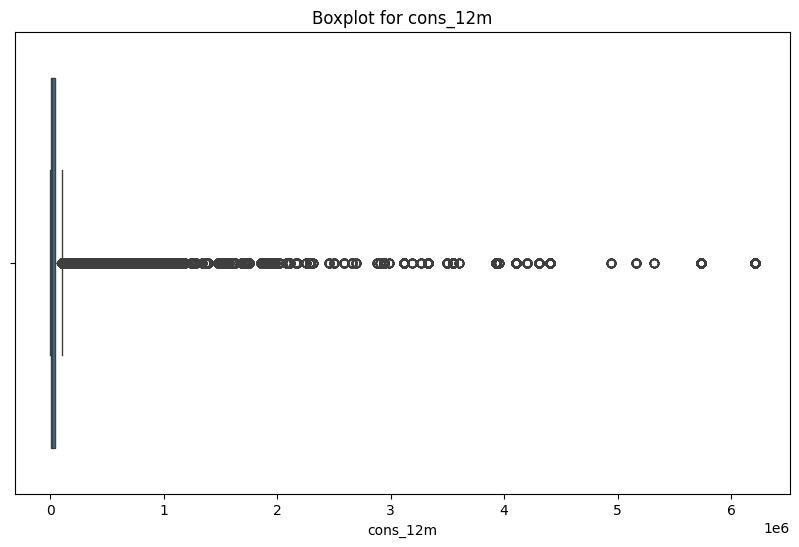

Outliers in cons_gas_12m: 22172 (17.07%)


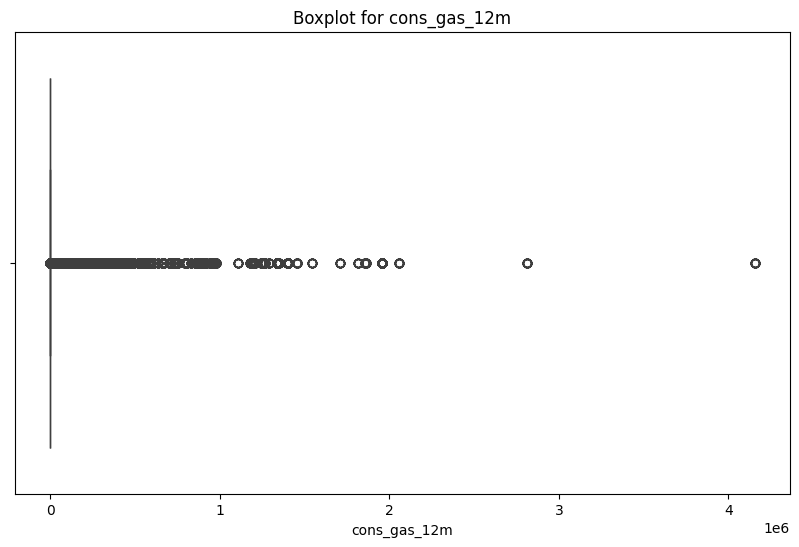

Outliers in cons_last_month: 19011 (14.64%)


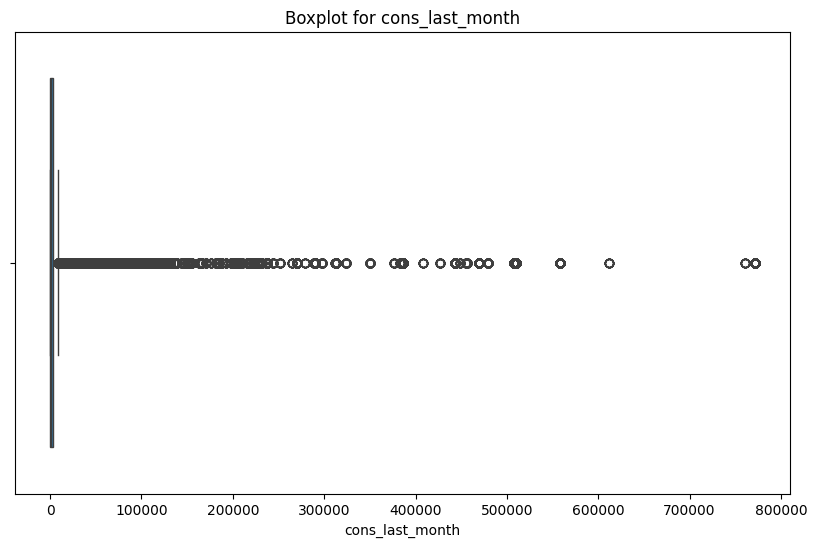

Outliers in forecast_cons_12m: 9025 (6.95%)


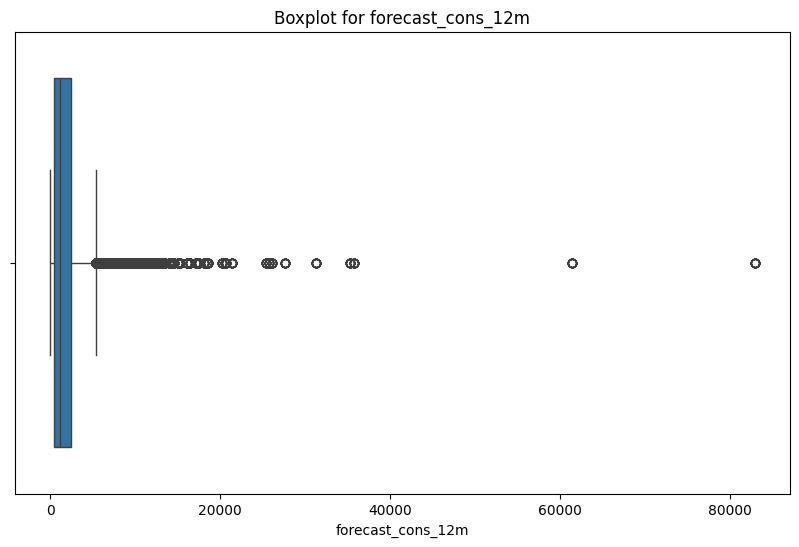

Outliers in forecast_cons_year: 11391 (8.77%)


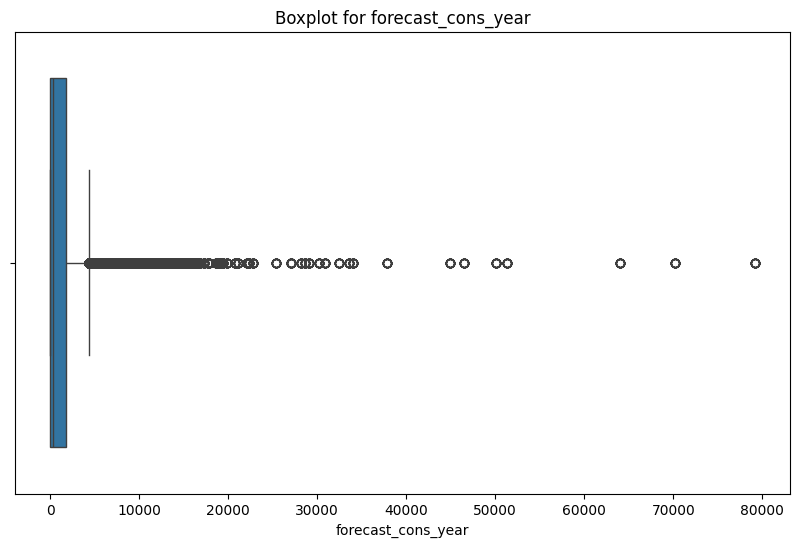

Outliers in forecast_discount_energy: 5096 (3.92%)


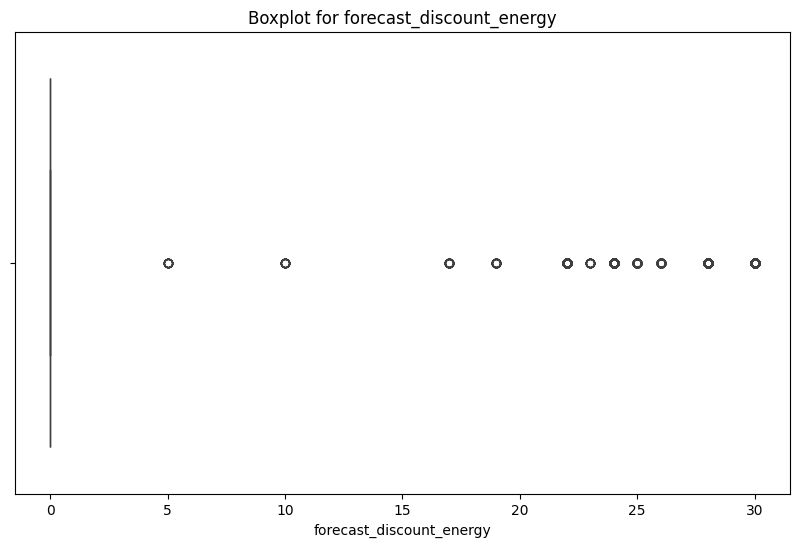

Outliers in forecast_meter_rent_12m: 1208 (0.93%)


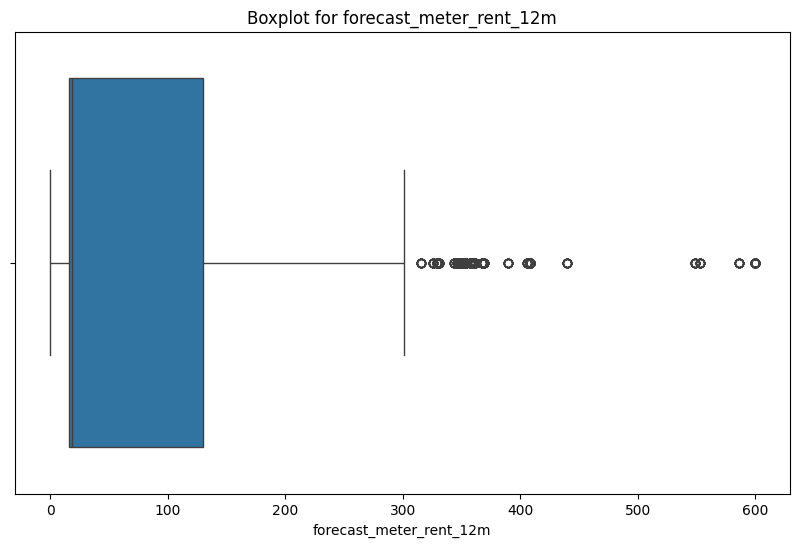

Outliers in forecast_price_energy_off_peak: 2890 (2.23%)


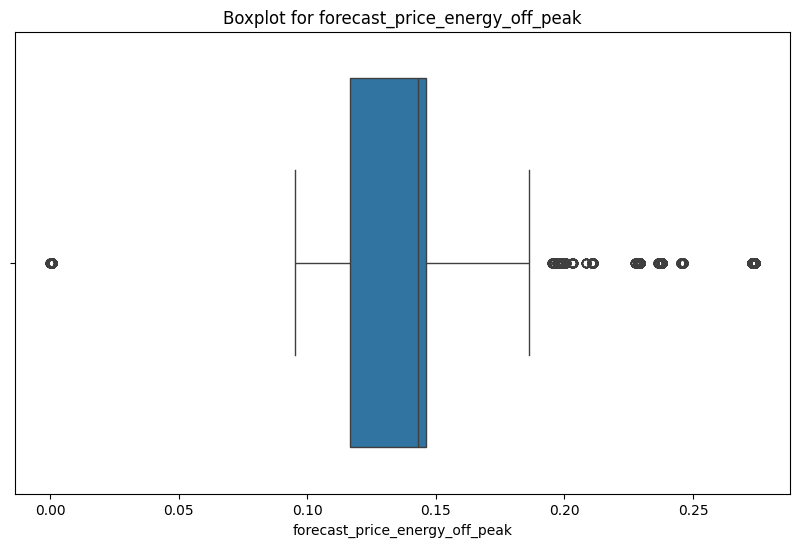

Outliers in forecast_price_energy_peak: 0 (0.00%)


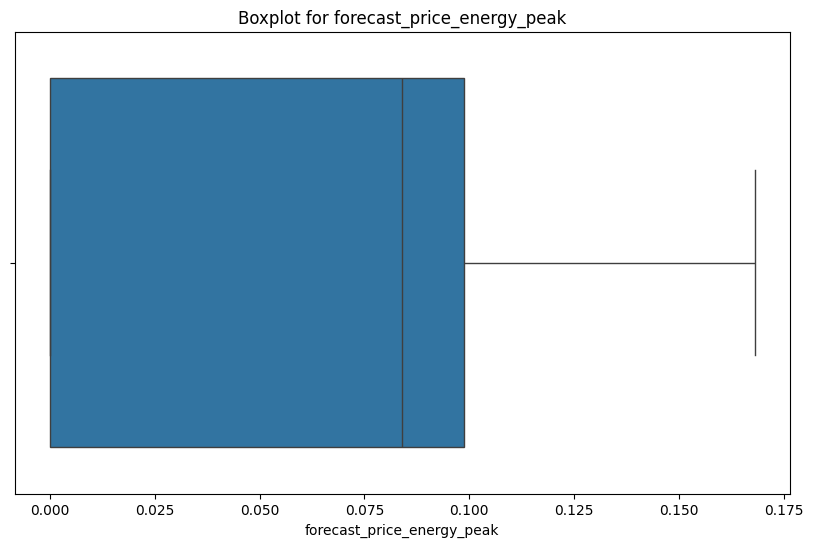

Outliers in forecast_price_pow_off_peak: 1512 (1.16%)


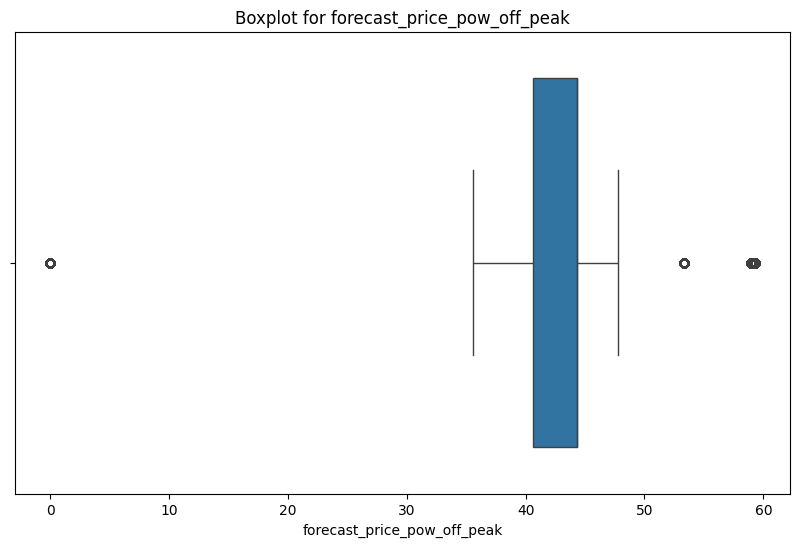

Outliers in has_gas: 22606 (17.41%)


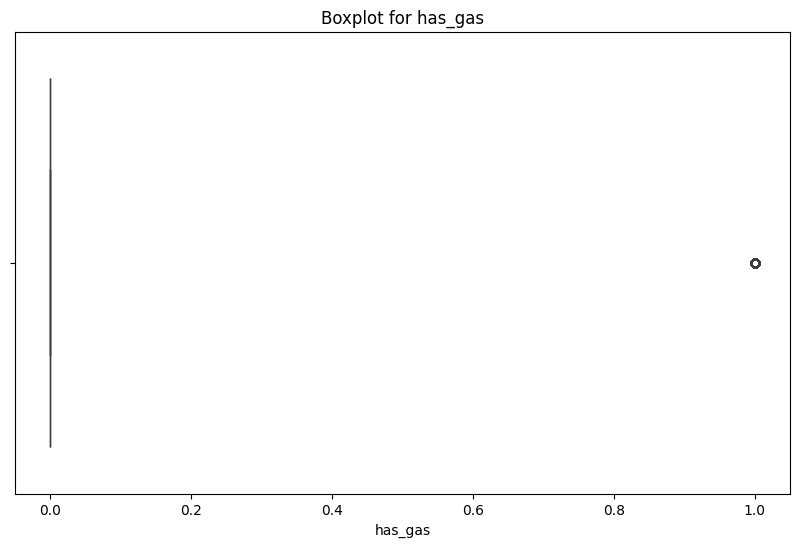

Outliers in imp_cons: 10742 (8.27%)


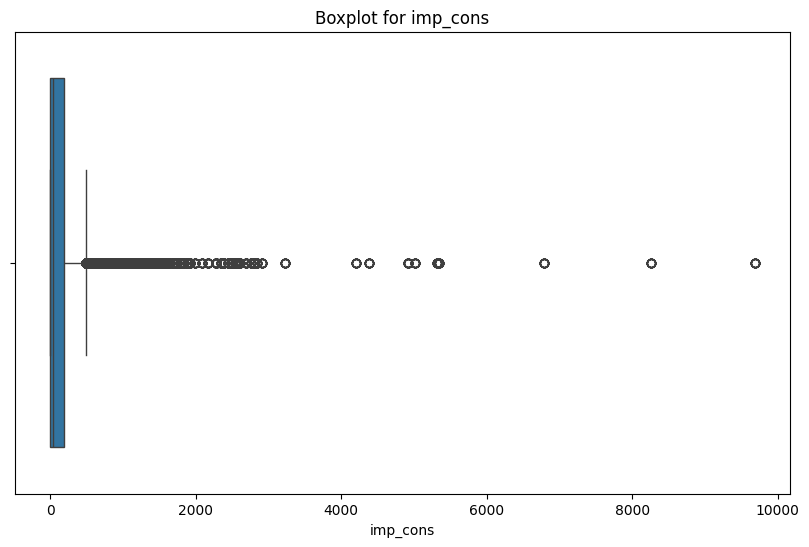

Outliers in margin_gross_pow_ele: 6333 (4.88%)


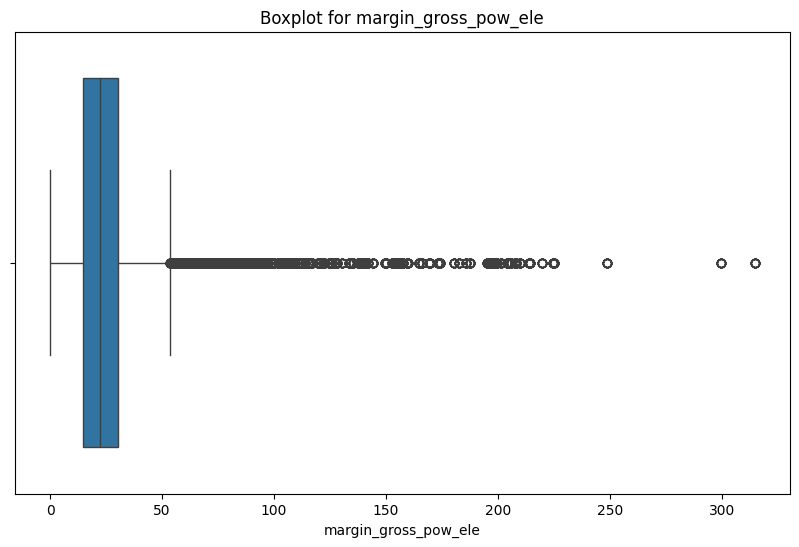

Outliers in margin_net_pow_ele: 6333 (4.88%)


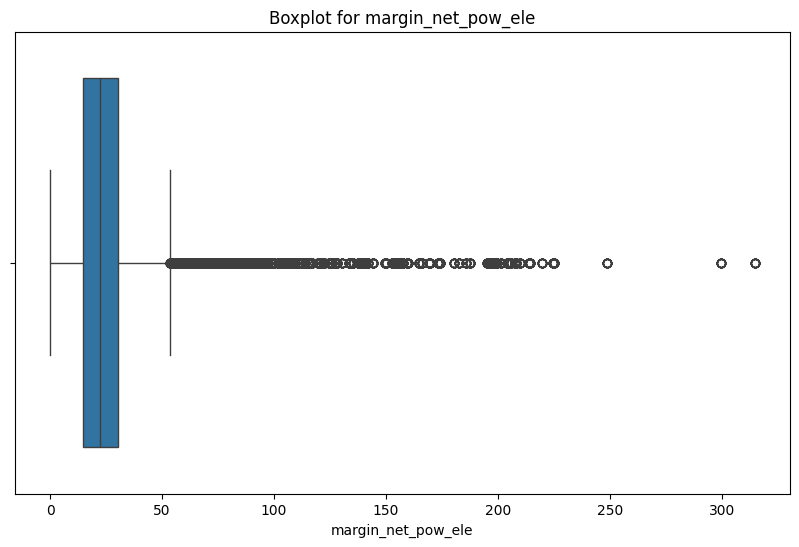

Outliers in nb_prod_act: 27302 (21.02%)


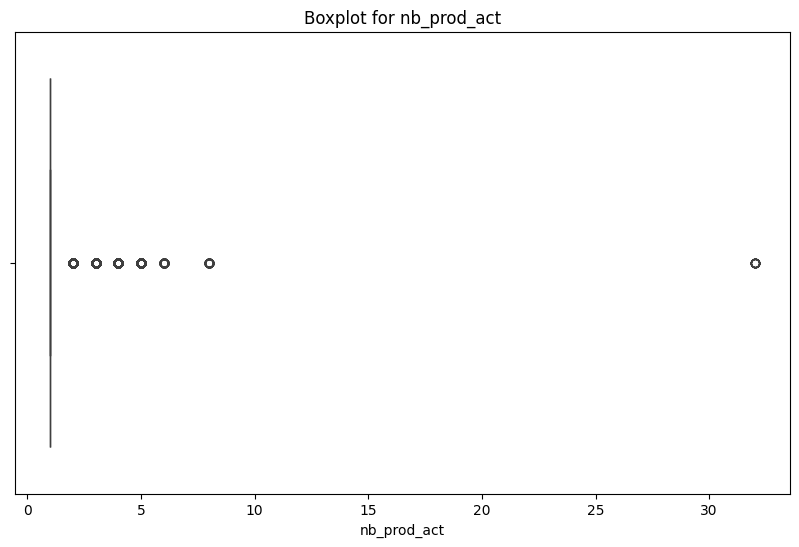

Outliers in net_margin: 8618 (6.64%)


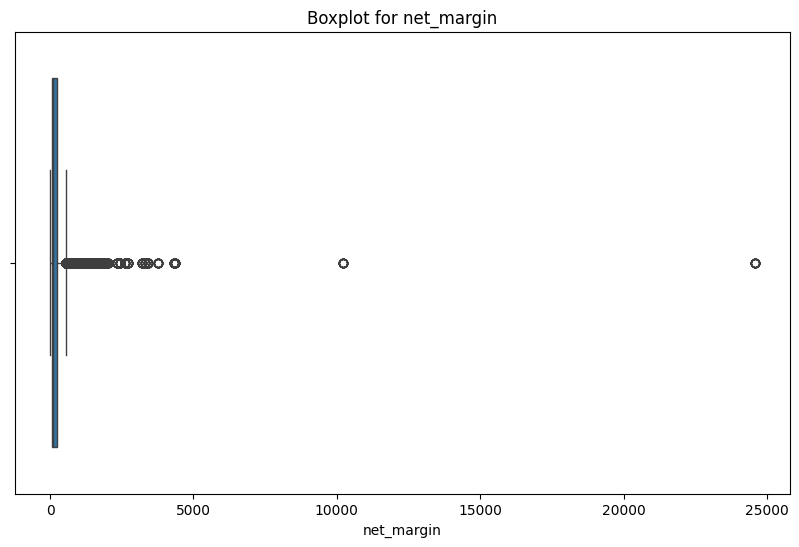

Outliers in num_years_antig: 288 (0.22%)


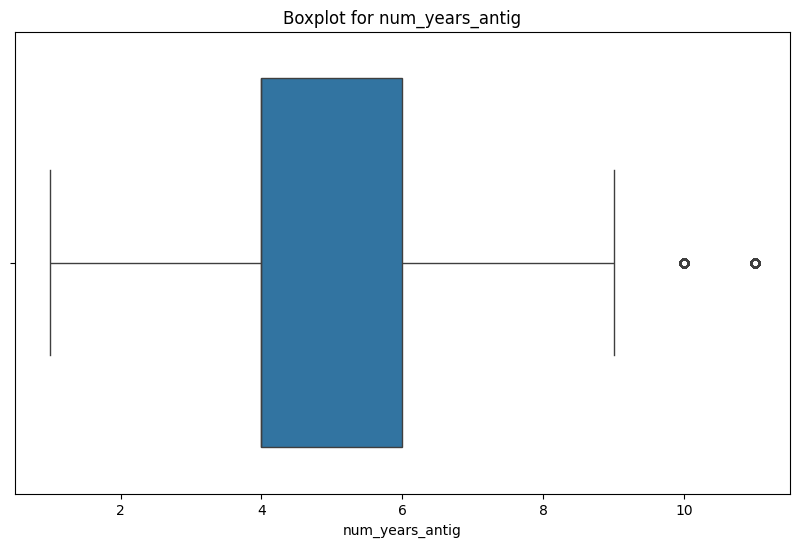

Outliers in pow_max: 13487 (10.39%)


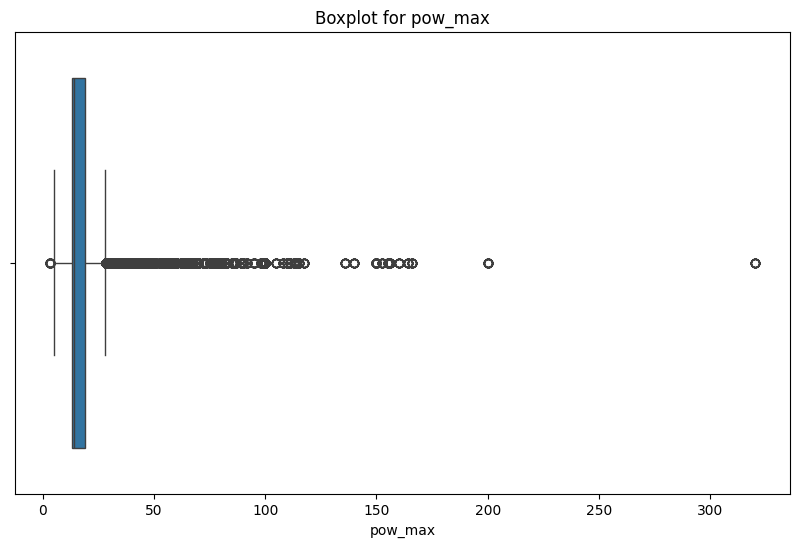

Outliers in churn: 13561 (10.44%)


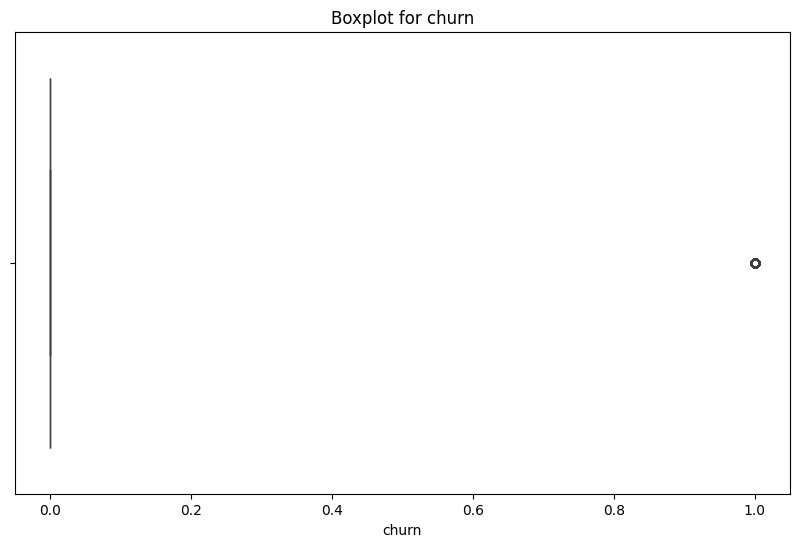

Outliers in price_off_peak_var: 3168 (2.44%)


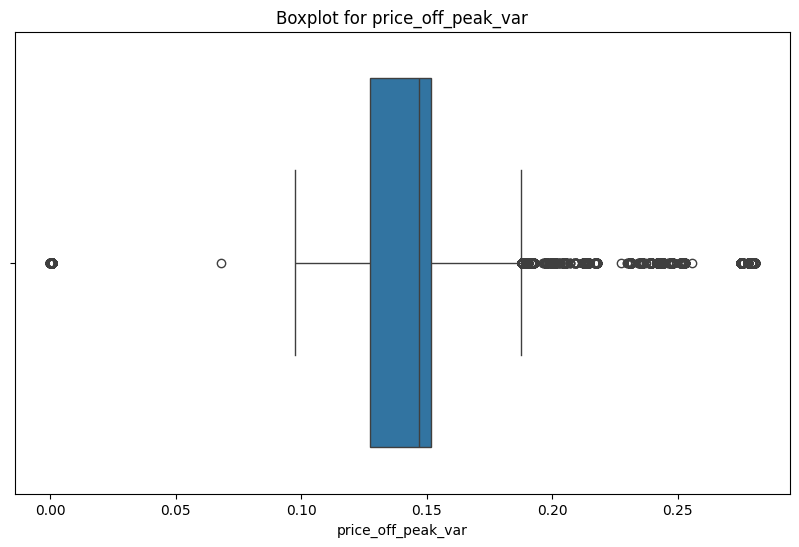

Outliers in price_peak_var: 0 (0.00%)


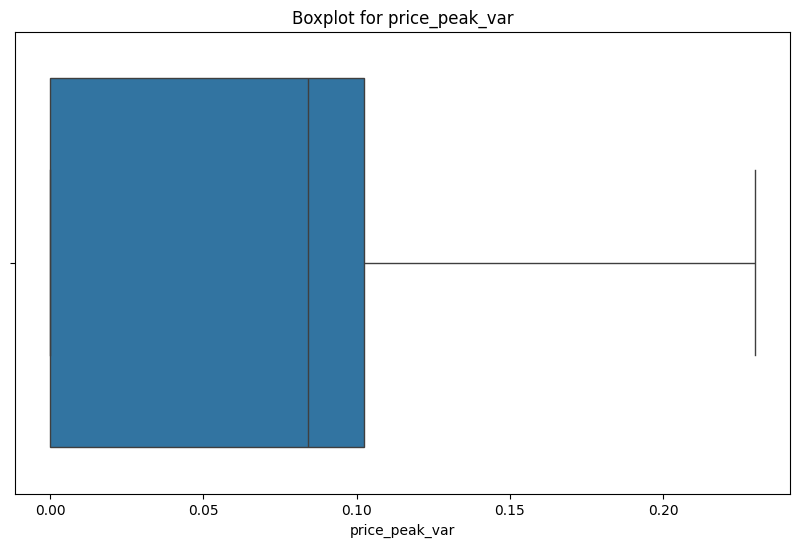

Outliers in price_mid_peak_var: 0 (0.00%)


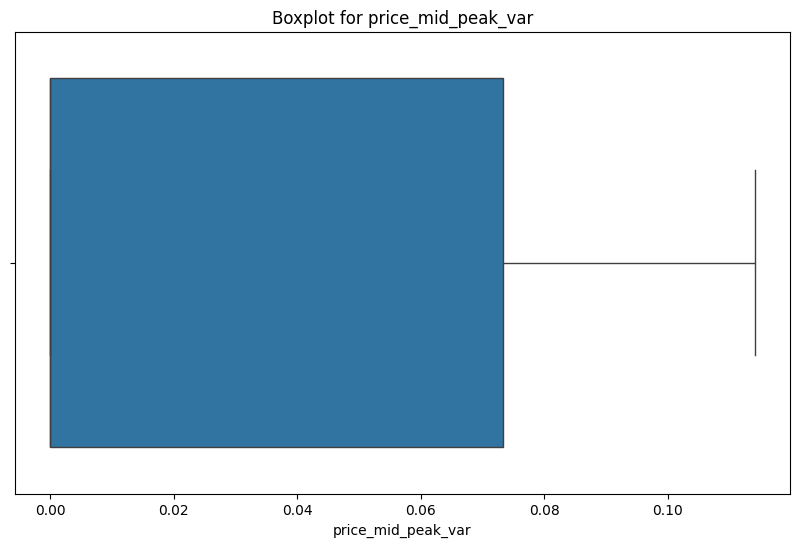

Outliers in price_off_peak_fix: 1421 (1.09%)


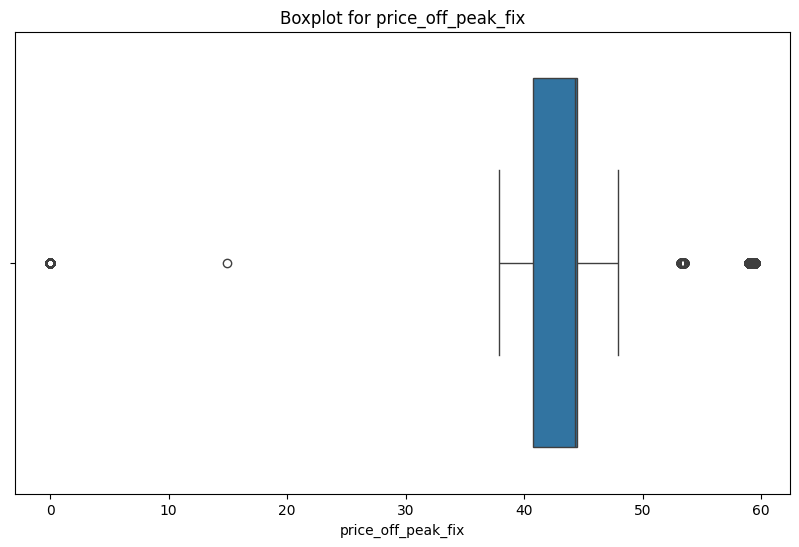

Outliers in price_peak_fix: 0 (0.00%)


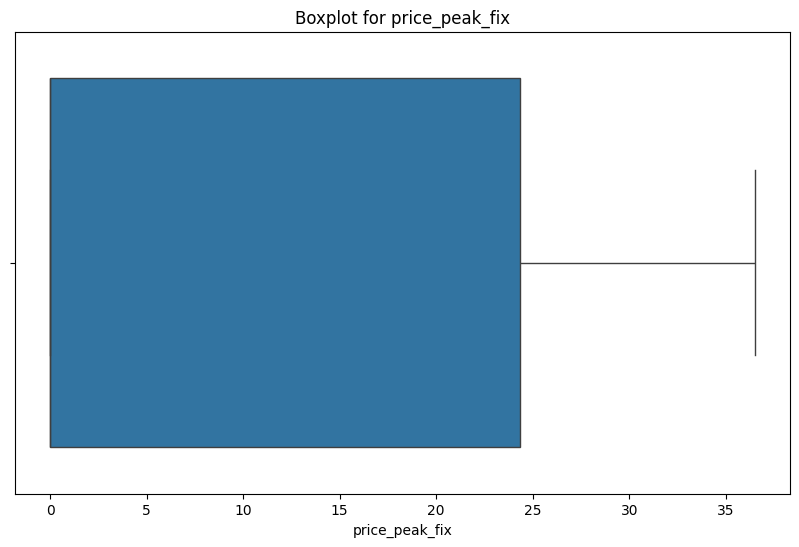

Outliers in price_mid_peak_fix: 0 (0.00%)


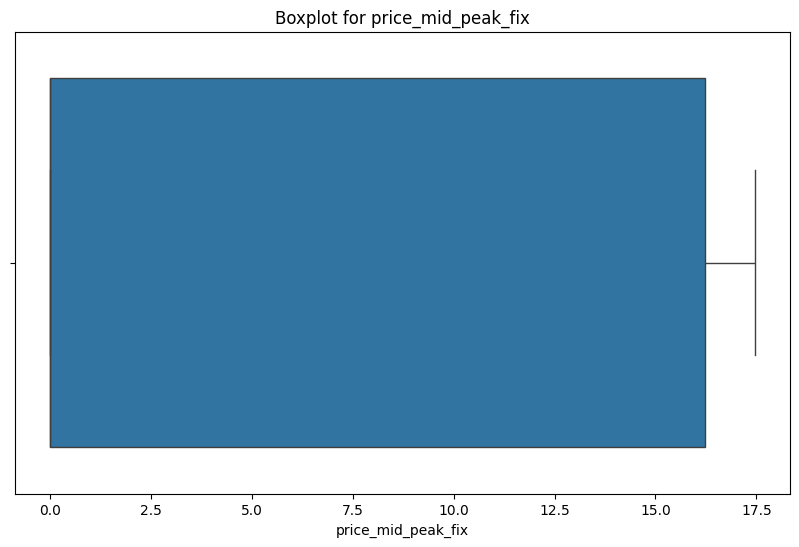

Outliers in price_sensitivity: 0 (0.00%)


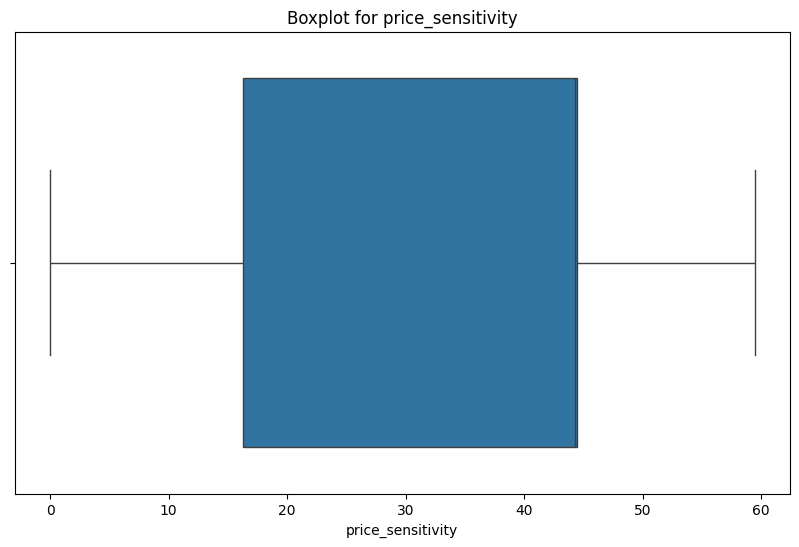

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify all numerical columns in the merged_df
numerical_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns

# Outlier detection using IQR for each numerical column
for col in numerical_columns:
    # Calculate Q1, Q3, and IQR
    Q1 = merged_df[col].quantile(0.25)
    Q3 = merged_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find the outliers
    outliers = merged_df[(merged_df[col] < lower_bound) | (merged_df[col] > upper_bound)]
    total_outliers = len(outliers)
    total_rows = len(merged_df)
    percentage_outliers = (total_outliers / total_rows) * 100

    print(f"Outliers in {col}: {total_outliers} ({percentage_outliers:.2f}%)")


    # Plotting the boxplot for each column
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=merged_df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()


In [45]:
merged_df['has_gas'].unique()

array([1, 0])

In [50]:
numerical_columns = [
    "cons_12m", "cons_gas_12m", "cons_last_month", "forecast_cons_12m", 
    "forecast_cons_year", "forecast_discount_energy", "forecast_meter_rent_12m",
    "forecast_price_energy_off_peak", "forecast_price_energy_peak", 
    "forecast_price_pow_off_peak", "imp_cons", "margin_gross_pow_ele",
    "margin_net_pow_ele", "nb_prod_act", "net_margin", "num_years_antig", "pow_max",
    "price_sensitivity", "churn"
]

# Z-score Method (without scipy)
def detect_outliers_zscore(df, columns, threshold=3):
    for col in columns:
        mean = df[col].mean()
        std_dev = df[col].std()
        z_scores = (df[col] - mean) / std_dev
        outliers = df[np.abs(z_scores) > threshold]
        print(f"Outliers in {col}: {outliers.shape[0]}")

# Apply the function on the merged dataset
detect_outliers_zscore(merged_df, numerical_columns)


Outliers in cons_12m: 2781
Outliers in cons_gas_12m: 1975
Outliers in cons_last_month: 2877
Outliers in forecast_cons_12m: 1440
Outliers in forecast_cons_year: 1691
Outliers in forecast_discount_energy: 5050
Outliers in forecast_meter_rent_12m: 1280
Outliers in forecast_price_energy_off_peak: 1728
Outliers in forecast_price_energy_peak: 0
Outliers in forecast_price_pow_off_peak: 1512
Outliers in imp_cons: 1583
Outliers in margin_gross_pow_ele: 2243
Outliers in margin_net_pow_ele: 2243
Outliers in nb_prod_act: 1676
Outliers in net_margin: 552
Outliers in num_years_antig: 312
Outliers in pow_max: 2507
Outliers in price_sensitivity: 0
Outliers in churn: 0


In [49]:
# Calculate price sensitivity
merged_df['price_sensitivity'] = merged_df['price_off_peak_fix'] - merged_df['price_peak_fix']

# Check the new feature
print(merged_df[['id', 'price_sensitivity', 'churn']].head())


                                 id  price_sensitivity  churn
0  24011ae4ebbe3035111d65fa7c15bc57          16.226389      1
1  24011ae4ebbe3035111d65fa7c15bc57          16.226389      1
2  24011ae4ebbe3035111d65fa7c15bc57          16.226395      1
3  24011ae4ebbe3035111d65fa7c15bc57          16.226395      1
4  24011ae4ebbe3035111d65fa7c15bc57          16.226395      1


In [51]:
import numpy as np

# List of numerical columns to process
numerical_columns = [
    "cons_12m", "cons_gas_12m", "cons_last_month", "forecast_cons_12m", 
    "forecast_cons_year", "forecast_discount_energy", "forecast_meter_rent_12m",
    "forecast_price_energy_off_peak", "forecast_price_energy_peak", 
    "forecast_price_pow_off_peak", "imp_cons", "margin_gross_pow_ele",
    "margin_net_pow_ele", "nb_prod_act", "net_margin", "num_years_antig", "pow_max", 
    "price_sensitivity"
]

# Step 1: Apply IQR-based outlier treatment
for col in numerical_columns:
    Q1 = merged_df[col].quantile(0.25)
    Q3 = merged_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    merged_df[col] = merged_df[col].clip(lower=lower_bound, upper=upper_bound)

# Step 2: Detect outliers using Z-score method
def detect_outliers_zscore(df, columns, threshold=3):
    for col in columns:
        mean = df[col].mean()
        std_dev = df[col].std()
        z_scores = (df[col] - mean) / std_dev
        outliers = df[np.abs(z_scores) > threshold]
        print(f"Outliers in {col}: {outliers.shape[0]}")

# Use the Z-score method on merged_df
detect_outliers_zscore(merged_df, numerical_columns)

# Step 3: Log transformation for positive values
for col in numerical_columns:
    if merged_df[col].min() > 0:  # Log transformation only for positive values
        merged_df[col] = np.log1p(merged_df[col])

# Step 4: Final filtering based on IQR bounds
for col in numerical_columns:
    Q1 = merged_df[col].quantile(0.25)
    Q3 = merged_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    merged_df = merged_df[(merged_df[col] >= lower_bound) & (merged_df[col] <= upper_bound)]


Outliers in cons_12m: 0
Outliers in cons_gas_12m: 0
Outliers in cons_last_month: 0
Outliers in forecast_cons_12m: 0
Outliers in forecast_cons_year: 0
Outliers in forecast_discount_energy: 0
Outliers in forecast_meter_rent_12m: 1316
Outliers in forecast_price_energy_off_peak: 156
Outliers in forecast_price_energy_peak: 0
Outliers in forecast_price_pow_off_peak: 1524
Outliers in imp_cons: 0
Outliers in margin_gross_pow_ele: 0
Outliers in margin_net_pow_ele: 0
Outliers in nb_prod_act: 0
Outliers in net_margin: 0
Outliers in num_years_antig: 492
Outliers in pow_max: 0
Outliers in price_sensitivity: 0


In [52]:
# Calculate Pearson correlation coefficient
correlation = merged_df['price_sensitivity'].corr(merged_df['churn'])
print(f"Correlation between price sensitivity and churn: {correlation}")


Correlation between price sensitivity and churn: -0.048151474673934255


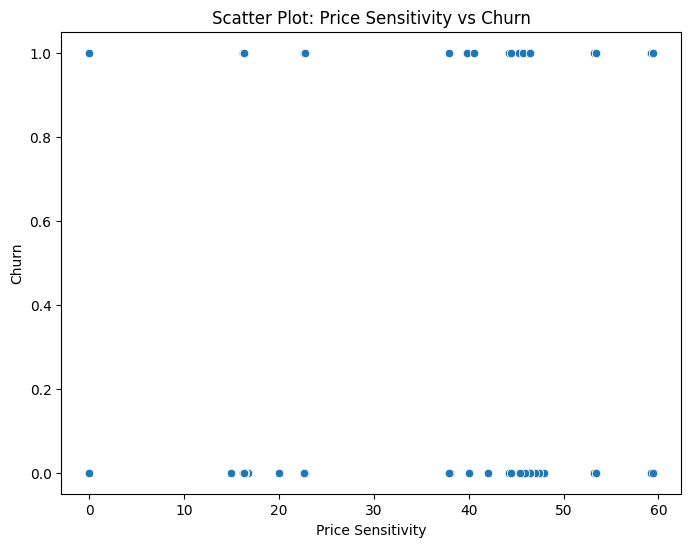

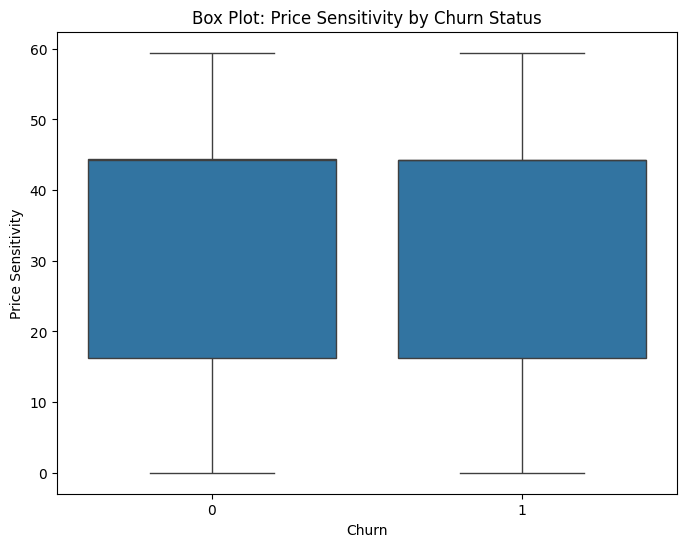

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='price_sensitivity', y='churn', data=merged_df)
plt.title('Scatter Plot: Price Sensitivity vs Churn')
plt.xlabel('Price Sensitivity')
plt.ylabel('Churn')
plt.show()

# Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='churn', y='price_sensitivity', data=merged_df)
plt.title('Box Plot: Price Sensitivity by Churn Status')
plt.xlabel('Churn')
plt.ylabel('Price Sensitivity')
plt.show()


In [54]:
from scipy.stats import ttest_ind

# Separate the data into churned and non-churned groups
churned = merged_df[merged_df['churn'] == 1]['price_sensitivity']
non_churned = merged_df[merged_df['churn'] == 0]['price_sensitivity']

# Perform t-test
t_stat, p_value = ttest_ind(churned, non_churned)

# Display the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Decision based on p-value (commonly α = 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in price sensitivity between churned and non-churned customers.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in price sensitivity between churned and non-churned customers.")


T-statistic: -17.34421342887176
P-value: 2.600351133795325e-67
Reject the null hypothesis: There is a significant difference in price sensitivity between churned and non-churned customers.


Since the p-value is significantly less than 0.05 (approximately 
2.6
×
1
0
−
67
2.6×10 
−67
 ), we can reject the null hypothesis and conclude that there is a significant difference in price sensitivity between churned and non-churned customers.

Key Insights:
Price sensitivity is a significant factor in churn, meaning it could potentially be used as a predictor for churn.


In [56]:
# Save the cleaned dataset
client_df_clean.to_csv('clean_data_after_eda.csv', index=False)


## Sub task 4

In [62]:
# 1. Import packages
import pandas as pd

# 2. Load the cleaned data
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

# 3. Load the price data
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')

# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean',
    'price_off_peak_fix': 'mean'
}).reset_index()

# Get January and December prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(
    dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}),
    jan_prices.drop(columns='price_date'),
    on='id'
)
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power']]

# Preview the result
print(diff.head())


df = df.merge(diff, on='id', how='left')

# Verify the feature exists in df
print(df.columns)

                                 id  offpeak_diff_dec_january_energy  \
0  0002203ffbb812588b632b9e628cc38d                        -0.006192   
1  0004351ebdd665e6ee664792efc4fd13                        -0.004104   
2  0010bcc39e42b3c2131ed2ce55246e3c                         0.050443   
3  0010ee3855fdea87602a5b7aba8e42de                        -0.010018   
4  00114d74e963e47177db89bc70108537                        -0.003994   

   offpeak_diff_dec_january_power  
0                        0.162916  
1                        0.177779  
2                        1.500000  
3                        0.162916  
4                       -0.000001  
Index(['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_activ', 'date_end', 'date_modif_prod', 'date_renewal',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off

## Implement Seasonal Trends and Feature Interactions for maximum impact

Objective:
Capture patterns such as year-over-year or month-over-month variations in pricing or consumption.

In [58]:
# Extract year from price_date
price_df['year'] = price_df['price_date'].dt.year

# Group by id and year to calculate annual averages
yearly_avg_prices = price_df.groupby(['id', 'year']).agg({
    'price_off_peak_var': 'mean',
    'price_off_peak_fix': 'mean'
}).reset_index()

# Calculate year-over-year changes for each customer
yearly_avg_prices['price_off_peak_var_yoy'] = yearly_avg_prices.groupby('id')['price_off_peak_var'].diff()
yearly_avg_prices['price_off_peak_fix_yoy'] = yearly_avg_prices.groupby('id')['price_off_peak_fix'].diff()

# Join back to the main dataframe
df = df.merge(yearly_avg_prices, on='id', how='left')


Capture nonlinear relationships between existing features to identify patterns influencing churn.


In [63]:
# Example: Interaction between price sensitivity and consumption
df['price_sensitivity_x_cons_12m'] = df['offpeak_diff_dec_january_energy'] * df['cons_12m']

# Example: Interaction between power price changes and consumption
df['power_price_change_ratio'] = df['offpeak_diff_dec_january_power'] / (df['cons_12m'] + 1e-5)  # Avoid division by zero


df.head(5)

Check if the new features have predictive power by calculating correlation with the target variable (churn).


The id is categorical (likely a string), and since it doesn’t contain information about customer behavior or other features influencing churn, it wouldn't help the model predict churn.
Including it could introduce noise, making the model more complex without any meaningful contribution to prediction accuracy.So we will be droping id

In [66]:
# Drop the 'id' column
df = df.drop(columns=['id'])

# Ensure that the dataframe only contains numeric columns for the model
df = df.select_dtypes(include=['number'])

# Proceed with training your Random Forest model


In [67]:
# Calculate correlation with churn
correlation_with_churn = df.corr()['churn'].sort_values(ascending=False)

# Display top correlated features
print(correlation_with_churn.head(10))


churn                           1.000000
margin_net_pow_ele              0.104799
margin_gross_pow_ele            0.104737
forecast_meter_rent_12m         0.052551
net_margin                      0.047704
pow_max                         0.045627
price_sensitivity_x_cons_12m    0.033161
forecast_price_energy_peak      0.030902
forecast_cons_12m               0.018739
power_price_change_ratio        0.016982
Name: churn, dtype: float64


Strong Correlation:
Churn is most highly correlated with itself, as expected, but margin_net_pow_ele and margin_gross_pow_ele both have a moderate correlation of around 0.10. These features are likely related to pricing or usage patterns and could be contributing to churn prediction.
Low Correlation:
Other features like forecast_meter_rent_12m, net_margin, and pow_max have relatively weak correlations (below 0.05) with churn, suggesting they might not directly affect the likelihood of churn.
Strategy 

Strategy Moving Forward:
Feature Importance Evaluation: For the Random Forest model, feature importance is a good way to identify which features are contributing most to the churn prediction. Even if a feature has low correlation with churn, it could still be valuable for the model. We can train the Random Forest model and inspect the feature importances to see which features contribute more to predicting churn.

Additional Feature Engineering: Features like price_sensitivity_x_cons_12m and power_price_change_ratio seem to have more predictive power based on this correlation. You could explore interactions between these features or refine them further.

Remove Low-Impact Features: Consider removing or reducing the weight of features with very low correlation to churn, as they may just add noise and increase the complexity of the model without improving its performance.

We have successfully recreated the feature "the difference between off-peak prices in December and January the preceding year" and explored ways to enhance it.
We discussed improving the feature's predictive power by exploring additional feature engineering ideas, considering feature importance, and refining the existing features.
Based on the feature correlations, we identified key drivers like price_sensitivity_x_cons_12m and power_price_change_ratio that might be valuable for churn prediction.

## Sub task 5

In [68]:
df.columns

Index(['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max', 'churn',
       'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power',
       'price_sensitivity_x_cons_12m', 'power_price_change_ratio'],
      dtype='object')

In [69]:
# Define target variable
y = df['churn']

# Define features
X = df.drop(columns=['churn'])

# Handle missing values (if any)
X = X.fillna(X.mean())

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


let's proceed with training the Random Forest classifier. We'll also evaluate its performance using suitable metrics such as accuracy, precision, recall, and F1-score.

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Classification report (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9031

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1944
           1       0.84      0.07      0.13       223

    accuracy                           0.90      2167
   macro avg       0.87      0.54      0.54      2167
weighted avg       0.90      0.90      0.86      2167


Confusion Matrix:
[[1941    3]
 [ 207   16]]


The model's accuracy is 90.31%, which looks quite promising at first glance. However, we should focus on a few other points from the classification report to get a clearer picture of its performance:

Precision and Recall:

Precision (Churn = 1): 0.84 — This means that when the model predicts a customer will churn, it is correct 84% of the time.
Recall (Churn = 1): 0.07 — This is quite low, meaning the model is only identifying 7% of the actual churned customers. This is a sign of imbalanced data or a bias towards predicting non-churners.
F1-score (Churn = 1): 0.13 — The F1-score is low because of the poor recall, which affects the balance between precision and recall.

Confusion Matrix:

The model correctly predicted 1941 non-churners (True Negatives) and 16 churners (True Positives).
It incorrectly predicted 207 churners as non-churners (False Negatives) and 3 non-churners as churners (False Positives).
Key Takeaways:
While the accuracy is high, the model struggles to identify the churners (the minority class), which is a critical issue for predicting customer churn. This suggests a class imbalance problem.
The model needs improvement in handling the minority class (churners).


Option 1: Resampling Techniques
We can use SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic examples for the minority class (churners) and improve the model's recall for the churn class.

Option 2: Class Weights Adjustment
Alternatively, we can adjust the class weights in the Random Forest model. This will penalize the model more for misclassifying the minority class (churners).

We will try both approaches and compare the performance.

In [72]:
!pip install imbalanced-learn



In [73]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split the dataset into features and target
X = df.drop('churn', axis=1)
y = df['churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Train a Random Forest classifier on the resampled data
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_res, y_res)

# Evaluate the model on the test set
y_pred = rf.predict(X_test)

In [74]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Print the classification report and confusion matrix
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8874019381633594
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      1944
           1       0.39      0.17      0.24       223

    accuracy                           0.89      2167
   macro avg       0.65      0.57      0.59      2167
weighted avg       0.86      0.89      0.87      2167

Confusion Matrix:
 [[1885   59]
 [ 185   38]]


Accuracy has decreased slightly to 88.74%. However, accuracy alone is not sufficient when dealing with imbalanced datasets.
Recall for churn (class 1): The recall for the churn class is 0.17, which is still quite low. This means the model is not effectively predicting many churners.
Precision for churn (class 1): The precision for churners is 0.39, which is also relatively low. This indicates that of the churn predictions made by the model, a substantial number are false positives.
F1-score for churn (class 1): The F1-score of 0.24 for churn is quite low, indicating the model's predictions for churn are not reliable.
Confusion Matrix: The matrix shows that most churners are still being misclassified, with only 38 churns predicted correctly out of 223.

Class Weight Adjustment Implementation

In [75]:
rf_weighted = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_weighted.fit(X_train, y_train)

# Evaluate the model
y_pred_weighted = rf_weighted.predict(X_test)


In [76]:
print("Accuracy (Weighted):", accuracy_score(y_test, y_pred_weighted))
print("Classification Report (Weighted):\n", classification_report(y_test, y_pred_weighted))
print("Confusion Matrix (Weighted):\n", confusion_matrix(y_test, y_pred_weighted))


Accuracy (Weighted): 0.9021688970927549
Classification Report (Weighted):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      1944
           1       0.87      0.06      0.11       223

    accuracy                           0.90      2167
   macro avg       0.88      0.53      0.53      2167
weighted avg       0.90      0.90      0.86      2167

Confusion Matrix (Weighted):
 [[1942    2]
 [ 210   13]]


Accuracy is similar to previous results, remaining at around 90.2%. However, the accuracy is again high due to the imbalance in the dataset.
Recall for churn (class 1): The recall for churn has decreased further to 0.06, which indicates that very few churn cases are being correctly predicted. This is still a significant problem, as the model is not detecting the majority of churners.
Precision for churn (class 1): The precision for churners has improved to 0.87, but it comes with the trade-off that many churn predictions are incorrect due to low recall.
F1-score for churn (class 1): The F1-score for churners remains 0.11, indicating that the model's ability to predict churn is still weak.
Confusion Matrix: The confusion matrix shows that most of the churners (210 out of 223) are still misclassified as non-churners, and only 13 churns are correctly predicted.

We will use GridSearchCV or RandomizedSearchCV to tune the hyperparameters of the Random Forest and optimize it for better performance, especially recall for the churn class.

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [84]:
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2', None]  # Replace 'auto' with valid options
}


In [85]:
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)


In [86]:
grid_search.fit(X_train, y_train)  # X_train and y_train are your training features and target


Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [87]:
print("Best parameters found: ", grid_search.best_params_)
best_rf = grid_search.best_estimator_


Best parameters found:  {'max_features': 'sqrt', 'n_estimators': 200}


In [88]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_rf.predict(X_test)  # X_test is your test feature set
print(classification_report(y_test, y_pred))  # y_test is the true labels for the test set
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1944
           1       0.94      0.07      0.13       223

    accuracy                           0.90      2167
   macro avg       0.92      0.53      0.54      2167
weighted avg       0.91      0.90      0.86      2167

[[1943    1]
 [ 208   15]]


The model performs well on class 0 (negative class) with a high precision (0.90) and recall (1.00).
The model performs poorly on class 1 (positive class), with very low recall (0.07) and F1-score (0.13). This indicates that it struggles to correctly identify the positive class, as reflected in the confusion matrix, where 208 true positives are misclassified as negatives.

Class Weighting in RandomForestClassifier


In [89]:
rf = RandomForestClassifier(n_estimators=200, max_features='sqrt', class_weight='balanced')
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200)

In [90]:
!pip install imbalanced-learn



In [91]:
from imblearn.over_sampling import SMOTE

# Create the SMOTE object
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Fit the model on the resampled data
rf = RandomForestClassifier(n_estimators=200, max_features='sqrt', class_weight='balanced')
rf.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(class_weight='balanced', n_estimators=200)

In [92]:
from sklearn.metrics import classification_report

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1944
           1       0.39      0.17      0.23       223

    accuracy                           0.89      2167
   macro avg       0.65      0.57      0.59      2167
weighted avg       0.86      0.89      0.87      2167



In [93]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define the model
rf = RandomForestClassifier(random_state=42)

# Define hyperparameters for randomized search
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),  # Number of trees
    'max_depth': [None, 10, 20, 30, 40, 50],  # Depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples for splitting
    'min_samples_leaf': [1, 2, 4],  # Minimum samples for leaf nodes
    'max_features': ['sqrt', 'log2', None],  # Feature selection strategies
    'bootstrap': [True, False]  # Bootstrap sampling
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
print(f"Best parameters: {random_search.best_params_}")

# Evaluate on the test set
y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': np.int64(300), 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1944
           1       0.67      0.07      0.13       223

    accuracy                           0.90      2167
   macro avg       0.79      0.53      0.54      2167
weighted avg       0.88      0.90      0.86      2167



## Trying XGBoos

In [94]:
pip install xgboost


   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   - -------------------------------------- 5.0/124.9 MB 32.7 MB/s eta 0:00:04
   ----- ---------------------------------- 16.5/124.9 MB 45.5 MB/s eta 0:00:03
   -------- ------------------------------- 25.2/124.9 MB 44.4 MB/s eta 0:00:03
   ----------- ---------------------------- 35.7/124.9 MB 45.6 MB/s eta 0:00:02
   ------------- -------------------------- 43.5/124.9 MB 45.3 MB/s eta 0:00:02
   ---------------- ----------------------- 51.4/124.9 MB 42.2 MB/s eta 0:00:02
   ----------------- ---------------------- 55.8/124.9 MB 39.6 MB/s eta 0:00:02
   ------------------- -------------------- 60.3/124.9 MB 37.2 MB/s eta 0:00:02
   -------------------- ------------------- 65.0/124.9 MB 35.4 MB/s eta 0:00:02
   ---------------------- ----------------- 69.5/124.9 MB 34.1 MB/s eta 0:00:02
   ----------------------- ---------------- 73.9/124.9 MB 32.9 MB/s eta 0:00:02
   ------------------------ --------------- 77.3/1

In [98]:
# Define features and target
X = client_df_clean.drop('churn', axis=1)  # Features: Drop the target column
y = client_df_clean['churn']  # Target: 'churn' column


In [105]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Select relevant features
features = df.drop('churn', axis=1)  # Dropping 'churn' column for now
target = df['churn']

# Handle missing values if any
features.fillna(features.mean(), inplace=True)

# Encode categorical variables (if any)
features = pd.get_dummies(features, drop_first=True)

# Normalize numerical features (if necessary)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2921
           1       0.78      0.04      0.08       329

    accuracy                           0.90      3250
   macro avg       0.84      0.52      0.51      3250
weighted avg       0.89      0.90      0.86      3250



In [100]:
client_df_clean.columns

Index(['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_activ', 'date_end', 'date_modif_prod', 'date_renewal',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn'],
      dtype='object')

In [101]:
# Define features and target
X = client_df_clean.drop('churn', axis=1)  # Features: Drop the 'churn' column
y = client_df_clean['churn']  # Target: 'churn' column


In [104]:
print(df.columns)



Index(['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max', 'churn',
       'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power',
       'price_sensitivity_x_cons_12m', 'power_price_change_ratio'],
      dtype='object')


## logistic regression

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Assuming `df` is your cleaned DataFrame with 'churn' as the target column
X = df.drop(columns=['churn'])  # Features
y = df['churn']  # Target variable

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Logistic Regression model with balanced class weights
log_reg_model = LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)
log_reg_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = log_reg_model.predict(X_test_scaled)

# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.59      0.72      1944
           1       0.14      0.61      0.23       223

    accuracy                           0.59      2167
   macro avg       0.54      0.60      0.48      2167
weighted avg       0.85      0.59      0.67      2167



In [108]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Step 1: Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 2: Hyperparameter tuning for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga']
}

log_reg = LogisticRegression(max_iter=1000, random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_resampled, y_resampled)

# Best parameters found by GridSearchCV
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Step 3: Evaluate the tuned Logistic Regression model
best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters: {'C': 1, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.93      0.63      0.75      1944
           1       0.15      0.57      0.24       223

    accuracy                           0.62      2167
   macro avg       0.54      0.60      0.49      2167
weighted avg       0.85      0.62      0.70      2167



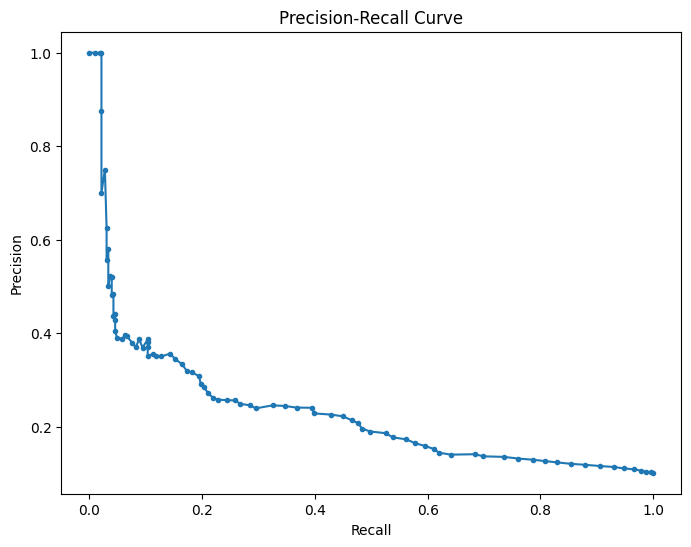

Threshold: 0.3
Precision: 0.2256
Recall: 0.4286
F1-score: 0.2956
Confusion Matrix:
[[2437  484]
 [ 188  141]]

Threshold: 0.4
Precision: 0.2564
Recall: 0.2432
F1-score: 0.2496
Confusion Matrix:
[[2689  232]
 [ 249   80]]

Threshold: 0.5
Precision: 0.3448
Recall: 0.1520
F1-score: 0.2110
Confusion Matrix:
[[2826   95]
 [ 279   50]]



In [111]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and target variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train your model here, assuming 'model' is already defined
model.fit(X_resampled, y_resampled)

# Predict probabilities for adjusting thresholds
y_probs = model.predict_proba(X_test)[:, 1]  # Only the probability of the positive class

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Now let's experiment with different thresholds
thresholds_to_try = [0.3, 0.4, 0.5]  # Try different thresholds

# Evaluate the model with different thresholds
for threshold in thresholds_to_try:
    y_pred_adjusted = (y_probs >= threshold).astype(int)
    
    # Calculate metrics
    precision_val = precision_score(y_test, y_pred_adjusted)
    recall_val = recall_score(y_test, y_pred_adjusted)
    f1_val = f1_score(y_test, y_pred_adjusted)
    cm = confusion_matrix(y_test, y_pred_adjusted)
    
    print(f"Threshold: {threshold}")
    print(f"Precision: {precision_val:.4f}")
    print(f"Recall: {recall_val:.4f}")
    print(f"F1-score: {f1_val:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")


In [117]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Assuming 'df' is your dataframe and 'churn' is the target column
# Prepare features and target
X = df.drop(columns=['churn'])
y = df['churn']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Logistic Regression with class weight balanced
log_reg = LogisticRegression(class_weight='balanced', max_iter=2000, solver='liblinear')

# Fit the model
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = log_reg.predict(X_test_scaled)

# Evaluate model performance
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculate additional metrics for thresholds
def evaluate_model_at_threshold(model, X, y, threshold=0.5):
    probas = model.predict_proba(X)[:, 1]
    predictions = (probas >= threshold).astype(int)
    
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)
    conf_matrix = confusion_matrix(y, predictions)
    
    print(f"Threshold: {threshold}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print("-" * 50)

# Evaluate the model at different thresholds
for threshold in [0.3, 0.4, 0.5]:
    evaluate_model_at_threshold(log_reg, X_test_scaled, y_test, threshold)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000, 3000]
}

grid_search = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Display best parameters from GridSearchCV
print("Best Parameters from Grid Search:")
print(grid_search.best_params_)

# Evaluate with the best parameters
best_log_reg = grid_search.best_estimator_
y_pred_best = best_log_reg.predict(X_test_scaled)

# Display performance of the best model
print("Classification Report for Best Model:")
print(classification_report(y_test, y_pred_best))
print("Confusion Matrix for Best Model:")
print(confusion_matrix(y_test, y_pred_best))


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.59      0.72      1944
           1       0.14      0.61      0.23       223

    accuracy                           0.59      2167
   macro avg       0.54      0.60      0.48      2167
weighted avg       0.85      0.59      0.67      2167

Confusion Matrix:
[[1143  801]
 [  88  135]]
Threshold: 0.3
Precision: 0.1081
Recall: 0.9596
F1-score: 0.1943
Confusion Matrix:
[[ 178 1766]
 [   9  214]]
--------------------------------------------------
Threshold: 0.4
Precision: 0.1181
Recall: 0.8475
F1-score: 0.2074
Confusion Matrix:
[[ 533 1411]
 [  34  189]]
--------------------------------------------------
Threshold: 0.5
Precision: 0.1442
Recall: 0.6054
F1-score: 0.2330
Confusion Matrix:
[[1143  801]
 [  88  135]]
--------------------------------------------------
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters from Grid Search:
{'C': 0.1, 'max_iter': 100

C:\Users\pspra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pspra\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Threshold vs Precision, Recall, F1-score:
    Threshold  Precision    Recall  F1-score
0        0.00   0.101231  1.000000  0.183850
1        0.05   0.107472  0.957447  0.193252
2        0.10   0.128283  0.638298  0.213632
3        0.15   0.226107  0.294833  0.255937
4        0.20   0.273585  0.088146  0.133333
5        0.25   0.319149  0.045593  0.079787
6        0.30   0.333333  0.033435  0.060773
7        0.35   0.300000  0.018237  0.034384
8        0.40   0.250000  0.012158  0.023188
9        0.45   0.307692  0.012158  0.023392
10       0.50   0.400000  0.012158  0.023599
11       0.55   0.500000  0.009119  0.017910
12       0.60   0.600000  0.009119  0.017964
13       0.65   0.500000  0.006079  0.012012
14       0.70   0.333333  0.003040  0.006024
15       0.75   0.500000  0.003040  0.006042
16       0.80   0.500000  0.003040  0.006042
17       0.85   0.500000  0.003040  0.006042
18       0.90   0.500000  0.003040  0.006042
19       0.95   0.500000  0.003040  0.006042
20       1.00

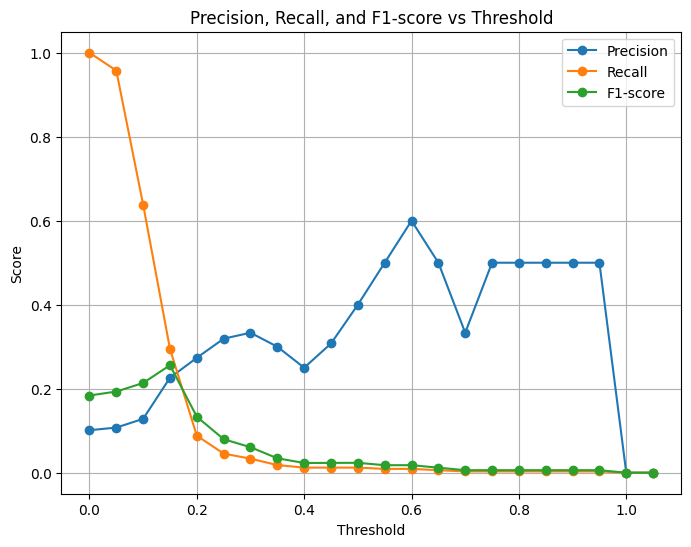


Best threshold for highest F1-score: 0.15000000000000002
Confusion Matrix for threshold 0.15000000000000002:
[[2589  332]
 [ 232   97]]


In [119]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Assuming your model has already been trained and you have your test set X_test and y_test

# Set the range of thresholds to evaluate (from 0 to 1, with a step of 0.05)
thresholds = np.arange(0.0, 1.1, 0.05)

# Store results for precision, recall, and F1-score at each threshold
results = []

# Evaluate for each threshold
for threshold in thresholds:
    # Apply the threshold to the predicted probabilities
    predictions = (model.predict_proba(X_test)[:, 1] >= threshold).astype(int)
    
    # Calculate precision, recall, and F1-score for the given threshold
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    
    # Store the results for this threshold
    results.append((threshold, precision, recall, f1))

# Convert the results list into a DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Threshold', 'Precision', 'Recall', 'F1-score'])

# Display the results
print("Threshold vs Precision, Recall, F1-score:")
print(results_df)

# Plot Precision, Recall, and F1-score against the threshold values
plt.figure(figsize=(8,6))
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='o')
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['F1-score'], label='F1-score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Determine the threshold that gives the best F1-score or any other metric you prefer
best_threshold = results_df.loc[results_df['F1-score'].idxmax()]['Threshold']
print(f"\nBest threshold for highest F1-score: {best_threshold}")

# Optionally: Calculate confusion matrix for the best threshold
predictions_best_threshold = (model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)
conf_matrix = confusion_matrix(y_test, predictions_best_threshold)
print(f"Confusion Matrix for threshold {best_threshold}:")
print(conf_matrix)

# You can adjust the threshold here based on the performance you want


Since you have already tried threshold tuning and are not seeing drastic improvements with Logistic Regression, combining Logistic Regression and Random Forest could be an effective way to boost performance without spending more time on tweaking a single model.

## combining both logistic regression and random forest

In [123]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Scale the features to avoid convergence issues
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the classifiers with adjusted max_iter for Logistic Regression
rf_model = RandomForestClassifier(random_state=42)
lr_model = LogisticRegression(random_state=42, max_iter=2000)

# Fit both models
rf_model.fit(X_train_scaled, y_train)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test_scaled)
lr_pred = lr_model.predict(X_test_scaled)

# Combine the predictions (simple majority voting)
combined_pred = (rf_pred + lr_pred) / 2
combined_pred = (combined_pred > 0.5).astype(int)  # Convert to binary classification

# Evaluate the performance
print("Accuracy:", accuracy_score(y_test, combined_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, combined_pred))
print("Classification Report:")
# Add zero_division=1 to handle cases where precision is undefined
print(classification_report(y_test, combined_pred, zero_division=1))


Accuracy: 0.8970927549607752
Confusion Matrix:
[[1944    0]
 [ 223    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1944
           1       1.00      0.00      0.00       223

    accuracy                           0.90      2167
   macro avg       0.95      0.50      0.47      2167
weighted avg       0.91      0.90      0.85      2167



In [125]:
# Assuming the dataset is loaded into df and "churn" is the target column

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Prepare data
X = df.drop(columns=['churn'])  # Features
y = df['churn']  # Target column 'churn'

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply scaling to features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

# Logistic Regression Model
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_scaled, y_train)

# Predictions and evaluation for Logistic Regression
y_pred_logreg = logreg_model.predict(X_test_scaled)

print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg)}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))

# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions and evaluation for Random Forest
y_pred_rf = rf_model.predict(X_test_scaled)

print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))


Logistic Regression Performance:
Accuracy: 0.8975542224273189
Confusion Matrix:
[[1942    2]
 [ 220    3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1944
           1       0.60      0.01      0.03       223

    accuracy                           0.90      2167
   macro avg       0.75      0.51      0.49      2167
weighted avg       0.87      0.90      0.85      2167


Random Forest Performance:
Accuracy: 0.9021688970927549
Confusion Matrix:
[[1940    4]
 [ 208   15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1944
           1       0.79      0.07      0.12       223

    accuracy                           0.90      2167
   macro avg       0.85      0.53      0.54      2167
weighted avg       0.89      0.90      0.86      2167



In [126]:
# Import necessary libraries
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Split the data into features and target
X = df.drop(columns='churn')  # Features
y = df['churn']  # Target column

# Resampling using SMOTE (oversampling minority class)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Standardize the data for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression with balanced class weights
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Evaluate the Logistic Regression model
print("Logistic Regression Performance:")
print("Accuracy:", log_reg.score(X_test_scaled, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log_reg))
print("Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print("AUC:", roc_auc_score(y_test, y_pred_log_reg))

# Train Random Forest with balanced class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate the Random Forest model
print("\nRandom Forest Performance:")
print("Accuracy:", rf.score(X_test, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_pred_rf))


Logistic Regression Performance:
Accuracy: 0.6491408934707904
Confusion Matrix:
[[1759 1182]
 [ 860 2019]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.60      0.63      2941
           1       0.63      0.70      0.66      2879

    accuracy                           0.65      5820
   macro avg       0.65      0.65      0.65      5820
weighted avg       0.65      0.65      0.65      5820

AUC: 0.6496905271072083

Random Forest Performance:
Accuracy: 0.9360824742268041
Confusion Matrix:
[[2816  125]
 [ 247 2632]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2941
           1       0.95      0.91      0.93      2879

    accuracy                           0.94      5820
   macro avg       0.94      0.94      0.94      5820
weighted avg       0.94      0.94      0.94      5820

AUC: 0.9358518857432245


In [127]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities from Logistic Regression and Random Forest
y_pred_prob_log_reg = log_reg.predict_proba(X_test_scaled)[:, 1]
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]

# Define a function to calculate precision, recall, and F1-score for different thresholds
def evaluate_threshold(y_true, y_probs):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    
    # Find the threshold with the highest F1-score
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = np.max(f1_scores)
    best_precision = precisions[np.argmax(f1_scores)]
    best_recall = recalls[np.argmax(f1_scores)]
    
    return best_threshold, best_precision, best_recall, best_f1

# Evaluate threshold for Logistic Regression
best_threshold_log_reg, best_precision_log_reg, best_recall_log_reg, best_f1_log_reg = evaluate_threshold(y_test, y_pred_prob_log_reg)
print(f"Best threshold for Logistic Regression: {best_threshold_log_reg}")
print(f"Precision: {best_precision_log_reg}, Recall: {best_recall_log_reg}, F1-score: {best_f1_log_reg}")

# Evaluate threshold for Random Forest
best_threshold_rf, best_precision_rf, best_recall_rf, best_f1_rf = evaluate_threshold(y_test, y_pred_prob_rf)
print(f"Best threshold for Random Forest: {best_threshold_rf}")
print(f"Precision: {best_precision_rf}, Recall: {best_recall_rf}, F1-score: {best_f1_rf}")


Best threshold for Logistic Regression: 0.3501703105135144
Precision: 0.5789824483448123, Recall: 0.9051754081278222, F1-score: 0.7062330623306234
Best threshold for Random Forest: 0.47
Precision: 0.9411971830985916, Recall: 0.9284473775616533, F1-score: 0.9347788074838258


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
